# Snow Analysis
### Purpose
This notebook will look at volunteer trends for reporting precipitation, adressing the Github issue #54  
(this notebook is a copy of the rain analysis notebook, but using both rain and snow data)

### Author: 
Hamza El-Saawy
### Date: 
2020-08-10
### Update Date: 
2020-08-10

### Inputs 
 - `1.3-rec-connecting-fips-ecosystem-data.txt`

### Output Files
None

## Steps or Proceedures in the notebook 
 - Clean the CBC ecological data 
 - Compare to NOAA data
 - Make some plots

## Where the Data will Be Saved 
n/a

## Notes
This notebook has all the same considerations as the rain and snow notebooks.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import scipy.stats as stats

In [4]:
import sklearn.metrics as metrics

In [5]:
sns.set(style="darkgrid")

In [6]:
# get the haversine distance formula fromt the script (w/o executing the '__main__' part)
%run -ni '../scripts/noaa.py'

In [7]:
#
# 
#

# drop all stations farther than this threshold (meters)
#  16km ~= 10 mi
DISTANCE_THRESHOLD = 15000

# drop all stations farther than this threshold (meters) in elevation
#  the farthest is 3.5km, with the mean being 70m and median being 23m
ELEVATION_THRESHOLD = 50

# consider stations to consense on a precipitation value if a fraction of them or more all have the same reading
# at the most abiguous, the fraction will be 0.5, so values are symmetric around 1/2: 0.25 in agreement is the same as 0.75 agreeing on the opposite
AGREEMENT_THRESHOLD = 0.75
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)

In [8]:
DATA_PATH = '../data/Cloud_Data'
ECO_DATA_PATH =  os.path.join(DATA_PATH, '1.3-rec-connecting-fips-ecosystem-data.txt')

In [10]:
eco_data = pd.read_csv(ECO_DATA_PATH, encoding = "ISO-8859-1", sep="\t")
eco_data = eco_data.rename(columns={'circle_name': 'c_name', 'circle_id': 'c_id',
                                    'lat': 'c_lat', 'lon': 'c_lon', 'circle_elev': 'c_elev',
                                    'Ecosys_circle': 'c_ecosys', 'Nlcd_code_circle': 'c_nlcdcode',
                                    'id': 's_id', 'latitude': 's_lat', 'longitude': 's_lon', 'elevation': 's_elev',
                                    'Ecosys_station': 's_ecosys', 'Nlcd_code_station': 's_nlcdcode',})

In [11]:
# drop all the other data that wont be needed
prcp_data = eco_data.loc[:, ['count_date', 'c_name', 'country_state', 'c_id', 'c_lat', 'c_lon',
                              'am_rain', 'pm_rain', 'am_snow', 'pm_snow', 'c_elev', 'c_ecosys', 'c_nlcdcode',
                              's_id', 's_lat', 's_lon', 's_elev', 's_ecosys', 's_nlcdcode', 'precipitation_value', 'snow',
                             ]]

## Data Prep

#### stations

In [25]:
prcp_data['s_rain'] = np.where(prcp_data.precipitation_value.isna(), pd.NA, prcp_data.precipitation_value > 0)
prcp_data['s_snow'] = np.where(prcp_data.snow.isna(), pd.NA, prcp_data.snow > 0)
# will propogate NAs as well as true/false
prcp_data['s_prcp'] = prcp_data.s_rain.astype('boolean') | prcp_data.s_snow.astype('boolean')

#### volunteer records

`[am|pm]_snow` are strings containing `1`:`4`, for heavy, light, none, or unknow snow.  
If the string contains `4`, then -- regardless of observations in that string (e.g. `2,4`) -- it will be marked as `NaN`  
If the string contains either `1` or `2` in the am or pm, then there was precipitation that day.   
If both am and pm are `3`, then there was no precipitation that day.  
Else, we mark `nan`

In [27]:
for c in ['am_rain', 'pm_rain', 'am_snow', 'pm_snow']:
    prcp_data.loc[prcp_data[c].isna(), c] = pd.NA
    prcp_data.loc[prcp_data[c].str.contains('4', na=False), c] = pd.NA

In [28]:
prcp_data['c_rain'] = pd.NA

prcp_data.loc[(prcp_data.am_rain.str.contains('[12]', na=False) | prcp_data.pm_rain.str.contains('[12]', na=False)), 'c_rain'] = True
prcp_data.loc[((prcp_data.am_rain == '3') & (prcp_data.pm_rain == '3')), 'c_rain'] = False

In [29]:
prcp_data['c_snow'] = pd.NA

prcp_data.loc[(prcp_data.am_snow.str.contains('[12]', na=False) | prcp_data.pm_snow.str.contains('[12]', na=False)), 'c_snow'] = True
prcp_data.loc[((prcp_data.am_snow == '3') & (prcp_data.pm_snow == '3')), 'c_snow'] = False

In [51]:
# converting to an object helps with aggregating the first value down below
#  dont ask ....
prcp_data['c_prcp'] = (prcp_data.c_rain.astype('boolean') | prcp_data.c_snow.astype('boolean')).astype('object')

## comparing stations and circles

In [32]:
prcp_data['distance'] = prcp_data.apply(lambda tt: haversine_formula((tt.c_lat, tt.c_lon), (tt.s_lat, tt.s_lon)), axis=1)

In [33]:
prcp_data['d_elev'] = np.abs(prcp_data.s_elev - prcp_data.c_elev)

In [34]:
# convert to int array to get nullable boolean arrays
#  https://pandas.pydata.org/pandas-docs/stable/user_guide/boolean.html#kleene-logical-operations
prcp_data['same_ecosys'] = prcp_data.c_ecosys.astype('Int64') == prcp_data.s_ecosys.astype('Int64')
prcp_data['same_nlcd'] = prcp_data.c_nlcdcode.astype('Int64') == prcp_data.s_nlcdcode.astype('Int64')

## data clean up

In [35]:
# drop everything outside of the distance or elevation threshold
prcp_data.drop(prcp_data[prcp_data.distance > DISTANCE_THRESHOLD].index, inplace=True)
prcp_data.drop(prcp_data[prcp_data.d_elev > ELEVATION_THRESHOLD].index, inplace=True)

In [ ]:
# once again dump excess data
prcp_data.drop(columns=['am_rain', 'pm_rain', 'am_snow', 'pm_snow','c_elev', 'c_rain', 'c_snow' 'c_nlcdcode', 'c_ecosys',  
                        's_elev', 's_rain', 's_snow', 's_ecosys', 's_nlcdcode', 'precipitation_value', 'snow',], inplace=True)

In [54]:
# isolate only the circle specific volunteer data
circle_obs = prcp_data[['count_date', 'c_name', 'country_state', 
                        'c_id', 'c_lat', 'c_lon', 'c_prcp']].groupby(['c_id', 'count_date']).agg('first')

In [55]:
# sort by circle then station information
prcp_data = prcp_data.set_index(['c_id', 'count_date', 's_id']).sort_index()

# Precipitation Analysis

In [63]:
g = prcp_data.groupby(level=['c_id', 'count_date'])

In [64]:
def prcp_calc(dfg):
    is_na = dfg.s_prcp.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    num = dfg.s_prcp.size + 0
    num_notna = dfg.s_prcp.count() + 0
    num_true = dfg.s_prcp.sum() + 0
    
    e = dfg.loc[dfg.same_ecosys, 's_prcp']
    e_num = e.size + 0
    e_num_notna = e.count() + 0
    e_num_true = e.sum() + 0
    
    n = dfg.loc[dfg.same_nlcd, 's_prcp']
    n_num = n.size + 0
    n_num_notna = n.count() + 0
    n_num_true = n.sum() + 0
    
    # havent figured out how to inlinse this yet ...
    lowest_id = dfg.d_elev.idxmin() if (num > 0) else np.NaN
    lowest_id_na = dfg.loc[~is_na, 'd_elev'].idxmin() if (num_notna > 0) else np.NaN
    
    return pd.Series({
        'num' : num,
        'num_notna' : num_notna,
        'num_true' : num_true,
        
        'e_num' : e_num,
        'e_num_notna' : e_num_notna,
        'e_num_true' : e_num_true,
        
        'n_num' : n_num,
        'n_num_notna' : n_num_notna,
        'n_num_true' : n_num_true,

        'p' : num_true / num_notna if (num_notna > 0) else np.NaN,
        'e_p' : e_num_true / e_num_notna if (e_num_notna > 0) else np.NaN,
        'n_p' : n_num_true / n_num_notna if (n_num_notna > 0) else np.NaN,
        
        'prcp_closest' : dfg.loc[dfg.distance.idxmin(), 's_prcp'] if (num > 0) else pd.NA,
        'prcp_closest_notna' : dfg.loc[dfg.loc[~is_na, 'distance'].idxmin(), 's_prcp'] if (num_notna > 0) else pd.NA,
        
        'prcp_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 's_prcp'],
        'prcp_lowest_notna' : pd.NA if pd.isna(lowest_id_na) else dfg.loc[lowest_id_na, 's_prcp'],
    })


In [65]:
circle_data = g.apply(prcp_calc)

In [66]:
circle_data = circle_obs.join(circle_data)

In [67]:
# if the stations couldnt agree (p ∈ [1-AGREEMENT_THRESHOLD, AGREEMENT_THRESHOLD]) or p is NaN, set the consenus to NaN as well
circle_data['consensus'] = np.where(((circle_data.p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.p <= AGREEMENT_THRESHOLD)) | circle_data.p.isna(), 
                                     pd.NA, circle_data.p >= AGREEMENT_THRESHOLD)

circle_data['e_consensus'] = np.where(((circle_data.e_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.e_p <= AGREEMENT_THRESHOLD)) | circle_data.e_p.isna(), 
                                     pd.NA, circle_data.e_p >= AGREEMENT_THRESHOLD)

circle_data['n_consensus'] = np.where(((circle_data.n_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.n_p <= AGREEMENT_THRESHOLD)) | circle_data.n_p.isna(), 
                                     pd.NA, circle_data.n_p >= AGREEMENT_THRESHOLD)

In [68]:
for c in ['consensus', 'e_consensus', 'n_consensus', 'prcp_closest', 'prcp_closest_notna', 'prcp_lowest', 'prcp_lowest_notna']:
    circle_data[c] = circle_data[c].astype('boolean')

## total stats

### the number of stations per circle

In [69]:
circle_data.num.describe()

count    68390.000000
mean         6.025808
std          7.684488
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        101.000000
Name: num, dtype: float64

Text(0.5, 0, 'number of stations')

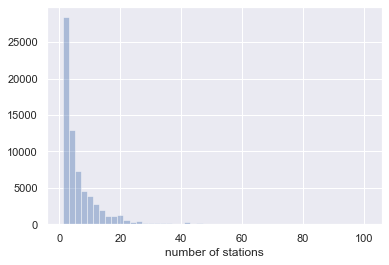

In [71]:
sns.distplot(circle_data.num, kde=False).set_xlabel("number of stations")

### the number of non-NaN stations per circle

In [72]:
circle_data.num_notna.describe()

count    68390.000000
mean         0.953853
std          1.295273
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         33.000000
Name: num_notna, dtype: float64

Text(0.5, 0, 'number of non-NaN stations')

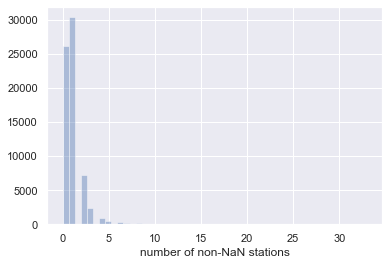

In [73]:
sns.distplot(circle_data.num_notna, kde=False).set_xlabel("number of non-NaN stations")

Text(0.5, 1.0, 'cumulative percent of stations missing')

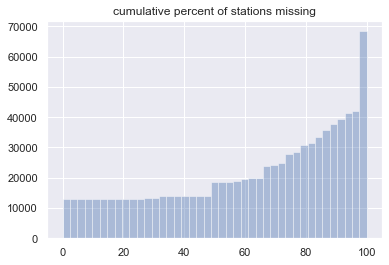

In [74]:
sns.distplot((1 - circle_data.num_notna/circle_data.num) * 100, kde=False, hist_kws={'cumulative': True}).set_title('cumulative percent of stations missing')

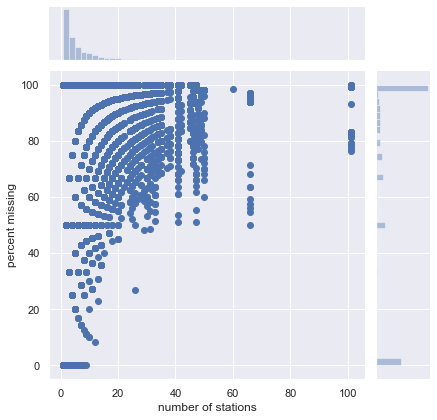

In [75]:
sns.jointplot(circle_data.num, (1 - circle_data.num_notna/circle_data.num) * 100).set_axis_labels("number of stations", 'percent missing')

#### percent of circles where all stations are missing data

In [76]:
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

38.179558414972945

#### percent of circles where no stations are missing data

In [77]:
((circle_data.num_notna == circle_data.num) & (circle_data.num > 0)).sum() / len(circle_data) * 100

18.860944582541308

#### percent of circles with less than half of stations missing

In [78]:
((circle_data.num_notna / circle_data.num) >= 0.5).sum() / len(circle_data) * 100

27.19110981137593

## the number of stations per circle by ecosystem

In [79]:
circle_data.n_num.describe()

count    68390.000000
mean         2.174675
std          3.956987
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         52.000000
Name: n_num, dtype: float64

In [80]:
circle_data.e_num.describe()

count    68390.000000
mean         1.517225
std          2.816323
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         26.000000
Name: e_num, dtype: float64

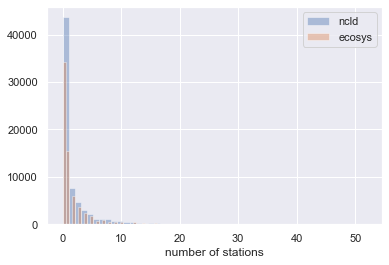

In [81]:
sns.distplot(circle_data.n_num, kde=False)
ax = sns.distplot(circle_data.e_num, kde=False)
ax.set_xlabel("number of stations")
ax.legend(["ncld", "ecosys"])

### the number of non-NaN stations per circle

In [82]:
circle_data.n_num_notna.describe()

count    68390.000000
mean         0.532402
std          1.062314
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         30.000000
Name: n_num_notna, dtype: float64

In [83]:
circle_data.e_num_notna.describe()

count    68390.000000
mean         0.371355
std          0.797829
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         15.000000
Name: e_num_notna, dtype: float64

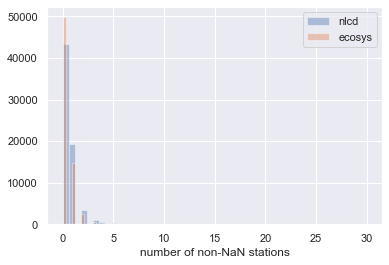

In [84]:
sns.distplot(circle_data.n_num_notna, kde=False)
ax = sns.distplot(circle_data.e_num_notna, kde=False)
ax.set_xlabel("number of non-NaN stations")
ax.legend(["nlcd", "ecosys"])

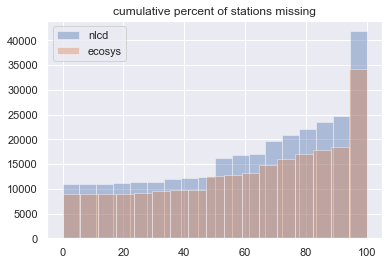

In [85]:
sns.distplot((1 - circle_data.n_num_notna/circle_data.n_num) * 100, kde=False, hist_kws={'cumulative': True})
ax = sns.distplot((1 - circle_data.e_num_notna/circle_data.e_num) * 100, kde=False, hist_kws={'cumulative': True})
ax.set_title('cumulative percent of stations missing')
ax.legend(["nlcd", "ecosys"])

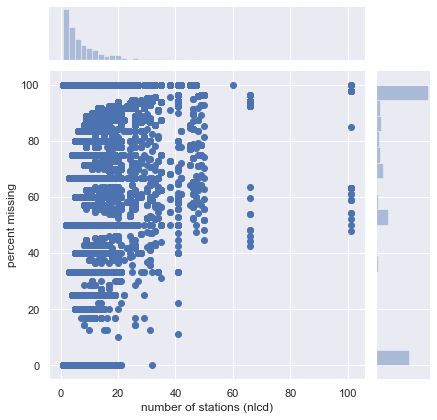

In [86]:
sns.jointplot(circle_data.num, (1 - circle_data.n_num_notna/circle_data.n_num) * 100).set_axis_labels("number of stations (nlcd)", 'percent missing')

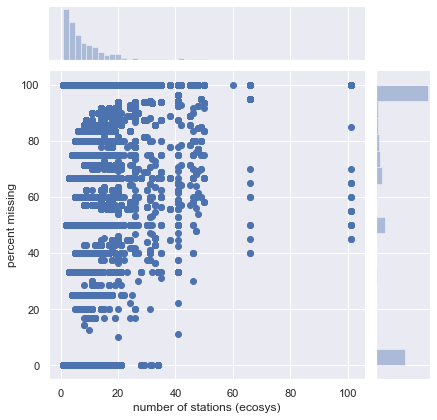

In [87]:
sns.jointplot(circle_data.num, (1 - circle_data.e_num_notna/circle_data.e_num) * 100).set_axis_labels("number of stations (ecosys)", 'percent missing')

#### percent of circles where all stations are missing data

In [88]:
(circle_data.n_num_notna == 0).sum() / len(circle_data) * 100

63.47711653750549

In [89]:
(circle_data.e_num_notna == 0).sum() / len(circle_data) * 100

72.83520982599795

#### percent of circles where no stations are missing data

In [90]:
((circle_data.n_num_notna == circle_data.n_num) & (circle_data.n_num > 0)).sum() / len(circle_data) * 100

16.084222839596432

In [91]:
((circle_data.e_num_notna == circle_data.e_num) & (circle_data.e_num > 0)).sum() / len(circle_data) * 100

12.991665448164936

#### percent of circles with less than half of stations missing

In [92]:
((circle_data.n_num_notna / circle_data.n_num) >= 0.5).sum() / len(circle_data) * 100

23.656967392893698

In [93]:
((circle_data.e_num_notna / circle_data.e_num) >= 0.5).sum() / len(circle_data) * 100

18.366720280742797

## location, location, location

#### what percent of circles had the closest station as NaN?

In [94]:
circle_data.prcp_closest.isna().sum() / len(circle_data) * 100

68.18394502120194

#### what percent had the average value differ from the closest value (ignoring NaNs)?

In [95]:
# use kleene logical indexing to skip over NAs
(circle_data.prcp_closest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.04094165813715455

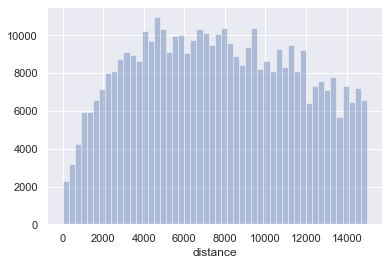

In [96]:
sns.distplot(prcp_data.distance, kde=False)

## elevation, elevation, elevation

#### what percent of circles had the lowest station as NaN?

In [97]:
circle_data.prcp_lowest.isna().sum() / len(circle_data) * 100

68.62845445240532

#### what percent had the average value differ from the lowest value (ignoring NaNs)?

In [98]:
# use kleene logical indexing to skip over NAs
(circle_data.prcp_lowest_notna ^ circle_data.consensus).sum() / len(circle_data) * 100

0.04971487059511624

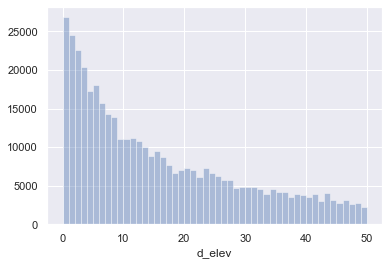

In [99]:
sns.distplot(prcp_data.d_elev, kde=False)

## consensus of stations
we use `4 * p(1-p)` to estiamte the "disagreement" amongst stations: this value ranges from `0` (all in agrement) to `1` (evenly split)  
(here, `p` is the fraction of non-NaN stations that are `True` for prcp)

### all stations

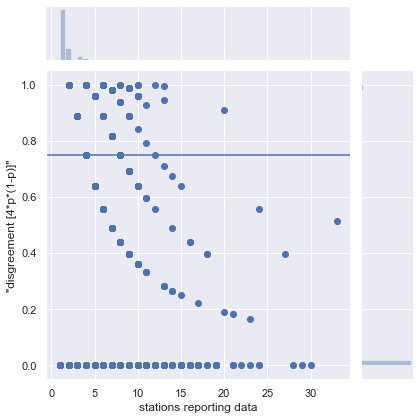

In [100]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p))
p.set_axis_labels("stations reporting data", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [101]:
(circle_data.consensus.isna() & circle_data.p.notna()).sum() / len(circle_data) * 100

3.2153823658429594

### ecosystems

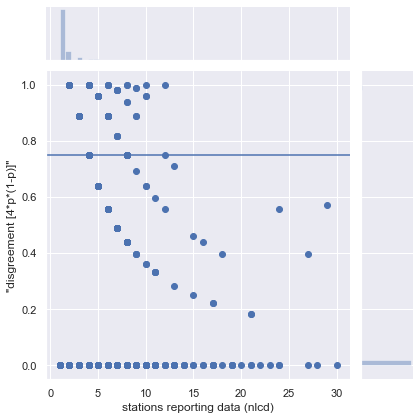

In [102]:
p = sns.jointplot(circle_data.n_num_notna, 4 * circle_data.n_p * (1 - circle_data.n_p))
p.set_axis_labels("stations reporting data (nlcd)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

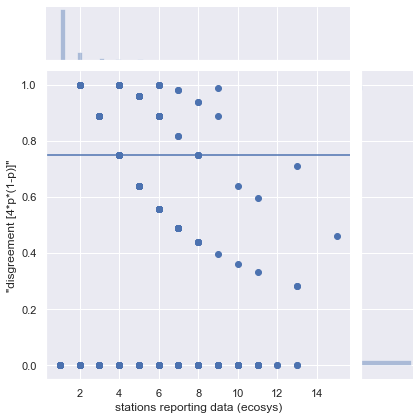

In [103]:
p = sns.jointplot(circle_data.e_num_notna, 4 * circle_data.e_p * (1 - circle_data.e_p))
p.set_axis_labels("stations reporting data (ecosys)", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

#### what percent do not meet our dissagreement threshold?

In [104]:
(circle_data.n_consensus.isna() & circle_data.n_p.notna()).sum() / len(circle_data) * 100

1.5119169469220646

In [105]:
(circle_data.e_consensus.isna() & circle_data.e_p.notna()).sum() / len(circle_data) * 100

0.9518935516888434

## the MISSING

In [106]:
circle_data_na_circle_idx = circle_data.c_prcp.isna()

### percent of circles with missing precipitation observation

In [107]:
circle_data_na_circle_idx.sum() / len(circle_data) * 100

58.96183652580787

### percent of circles with both volunteer and all station data are missing

In [108]:
# joint
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / len(circle_data) * 100

20.870010235414536

In [109]:
# conditional 
(circle_data_na_circle_idx & (circle_data.num_notna == 0)).sum() / circle_data_na_circle_idx.sum() * 100

35.3957940680488

In [110]:
# population
(circle_data.num_notna == 0).sum() / len(circle_data) * 100

38.179558414972945

correlation between the two

In [111]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna == 0))
g, p

(322.32251624091464, 4.5186899567160933e-72)

if the circle is missing data, it is much more likely that all other stations will too, when compared to the general population

### percent of circles with both volunteer and the closest station data are missing

In [112]:
# joint
(circle_data_na_circle_idx & circle_data.prcp_closest.isna()).sum()  / len(circle_data) * 100

36.37227664863284

In [113]:
# conditional 
(circle_data_na_circle_idx & circle_data.prcp_closest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

61.68782858843369

In [114]:
# population
circle_data.prcp_closest.isna().sum() / len(circle_data) * 100

68.18394502120194

In [115]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.prcp_closest.isna()))
g, p

(1910.6847038755247, 0.0)

if the circle is missing data, it is much **less** likely that the closest station will have missing data, when compared to the general population

### percent of circles with both volunteer and the lowest station data are missing

In [116]:
# joint
(circle_data_na_circle_idx & circle_data.prcp_lowest.isna()).sum()  / len(circle_data) * 100

36.82994589852318

In [117]:
# conditional 
(circle_data_na_circle_idx & circle_data.prcp_lowest.isna()).sum() / circle_data_na_circle_idx.sum() * 100

62.46404126574745

In [118]:
# population
circle_data.prcp_lowest.isna().sum() / len(circle_data) * 100

68.62845445240532

In [119]:
g, p, dof, expctd = stats.chi2_contingency(pd.crosstab(circle_data_na_circle_idx, circle_data.prcp_lowest.isna()))
g, p

(1733.5816640551773, 0.0)

if the circle is missing data, it is much **less** likely that the lowest station will have missing data, when compared to the general population

### number of stations for circles with missing data

In [120]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.num_notna)
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(838.6090786971549, 8.978652274963771e-158)

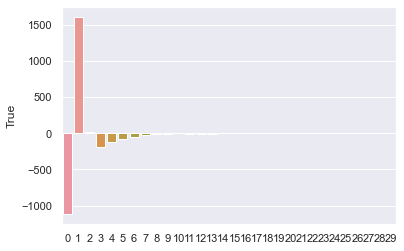

In [121]:
sns.barplot(np.arange(expctd.shape[1]), actl.loc[True] - expctd[1, :])

it looks like the circle being missing implies that there is only one non-na station?

### disagreement

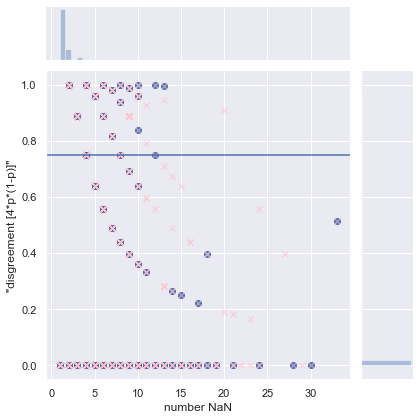

In [122]:
# "disagreement" (4*p*(1-p)) by number of not NA
# horizontal line is AGREEMENT_THRESHOLD, defined above
p = sns.jointplot(circle_data.loc[circle_data_na_circle_idx, 'num_notna'], 
                  4 * circle_data.loc[circle_data_na_circle_idx, 'p'] * (1 - circle_data.loc[circle_data_na_circle_idx, 'p']))
p.ax_joint.scatter(circle_data.num_notna, 4 * circle_data.p * (1 - circle_data.p), color='pink', marker='x', alpha=0.5)
p.set_axis_labels("number NaN", '"disgreement [4*p*(1-p)]"')
p.ax_joint.axhline(y = 4 * AGREEMENT_THRESHOLD * (1-AGREEMENT_THRESHOLD))

what percent do not meet our dissagreement threshold?

In [123]:
# joint
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / len(circle_data) * 100

22.446264073694984

In [124]:
# conditional
circle_data.loc[circle_data_na_circle_idx, 'consensus'].isna().sum() / circle_data_na_circle_idx.sum() * 100

38.069139966273184

In [125]:
# population
circle_data.consensus.isna().sum() / len(circle_data) * 100

41.39494078081591

In [126]:
actl = pd.crosstab(circle_data_na_circle_idx, circle_data.consensus.isna())
g, p, dof, expctd = stats.chi2_contingency(actl)
g, p

(447.67401730801083, 2.313751207309354e-99)

In [127]:
actl - expctd

consensus,False,True
c_prcp,,
False,-1341.09592,1341.09592
True,1341.09592,-1341.09592


missing your precipitation data imples the stations are more likely to consense

# the truth

get a feel for all the different precipitation measures 

how often does it precipitate?

In [128]:
circle_data.consensus.sum()/ circle_data.consensus.count()

0.32287924151696606

### location & consensus

In [129]:
pd.crosstab(circle_data.consensus, circle_data.prcp_closest_notna)

prcp_closest_notna,False,True
consensus,,
False,27128,11
True,17,12924


In [130]:
pd.crosstab(circle_data.consensus, circle_data.prcp_lowest_notna)

prcp_lowest_notna,False,True
consensus,,
False,27075,14
True,20,12812


In [131]:
pd.crosstab(circle_data.prcp_closest_notna, circle_data.prcp_lowest_notna)

prcp_lowest_notna,False,True
prcp_closest_notna,,
False,27698,461
True,480,13480


### ecosystem consensus

In [132]:
pd.crosstab(circle_data.consensus, circle_data.n_consensus)

n_consensus,False,True
consensus,,
False,15865,1
True,3,7484


In [133]:
pd.crosstab(circle_data.consensus, circle_data.e_consensus)

e_consensus,False,True
consensus,,
False,11807,2
True,3,5475


In [134]:
pd.crosstab(circle_data.n_consensus, circle_data.e_consensus)

e_consensus,False,True
n_consensus,,
False,12024,1
True,0,5662


### vs the lowest possible bar
(did just one station see precipitation?)

In [135]:
pd.crosstab(circle_data.prcp_closest_notna, circle_data.num_true > 0)

num_true,False,True
prcp_closest_notna,,
False,27032,1177
True,0,14070


In [136]:
pd.crosstab(circle_data.prcp_lowest_notna, circle_data.num_true > 0)

num_true,False,True
prcp_lowest_notna,,
False,26982,1196
True,0,13941


In [137]:
pd.crosstab(circle_data.consensus, circle_data.num_true > 0)

num_true,False,True
consensus,,
False,27032,107
True,0,12941


In [138]:
pd.crosstab(circle_data.consensus, circle_data.n_num_true > 0)

n_num_true,False,True
consensus,,
False,27062,77
True,5432,7509


In [139]:
pd.crosstab(circle_data.consensus, circle_data.e_num_true > 0)

e_num_true,False,True
consensus,,
False,27087,52
True,7442,5499


# circle v station: the whole point

In [140]:
def crosstab_metrics(actl):
    # accuracy
    acc = actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()
    # precision
    pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
    # recall
    re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
    # F1
    f1 = 2 * pr * re / (pr + re)
    
    print(f"accuracy:  {acc*100:.2f}%")
    print(f"precision: {pr*100:.2f}%")
    print(f"recall:    {re*100:.2f}%")
    print(f"F1:        {f1*100:.2f}%")
    
#     return (acc, pr, re, f1)

### based on the stations' consensus

In [141]:
actl = pd.crosstab(circle_data.consensus, circle_data.c_prcp)
actl

c_prcp,False,True
consensus,,
False,4933,2795
True,1541,5838


In [142]:
crosstab_metrics(actl)

accuracy:  71.30%
precision: 67.62%
recall:    79.12%
F1:        72.92%


### based on the closest station

In [143]:
actl = pd.crosstab(circle_data.prcp_closest_notna, circle_data.c_prcp)
actl

c_prcp,False,True
prcp_closest_notna,,
False,5140,3129
True,1736,6223


In [144]:
crosstab_metrics(actl)

accuracy:  70.02%
precision: 66.54%
recall:    78.19%
F1:        71.90%


### based on the lowest station

In [145]:
actl = pd.crosstab(circle_data.prcp_lowest_notna, circle_data.c_prcp)
actl

c_prcp,False,True
prcp_lowest_notna,,
False,5111,3136
True,1740,6143


In [146]:
crosstab_metrics(actl)

accuracy:  69.77%
precision: 66.20%
recall:    77.93%
F1:        71.59%


### based on the nlcd consensus

In [147]:
actl = pd.crosstab(circle_data.n_consensus, circle_data.c_prcp)
actl

c_prcp,False,True
n_consensus,,
False,3011,1682
True,973,3498


In [148]:
crosstab_metrics(actl)

accuracy:  71.03%
precision: 67.53%
recall:    78.24%
F1:        72.49%


### based on the ecosys consensus

In [149]:
actl = pd.crosstab(circle_data.e_consensus, circle_data.c_prcp)
actl

c_prcp,False,True
e_consensus,,
False,2292,1264
True,742,2627


In [150]:
crosstab_metrics(actl)

accuracy:  71.03%
precision: 67.51%
recall:    77.98%
F1:        72.37%


### did atleast one station aggree?

In [151]:
actl = pd.crosstab(circle_data.num_true >= 1, circle_data.c_prcp)
actl

c_prcp,False,True
num_true,,
False,9874,9624
True,1968,6600


In [152]:
crosstab_metrics(actl)

accuracy:  58.70%
precision: 40.68%
recall:    77.03%
F1:        53.24%
